# Training a CNN + FNO on the linear SWE on a 1D sphere


### Initialize

In [73]:
save_plots = 1
save_results = 1
n_epochs_CNN = 500
n_epochs_FNO = 100

# Define initial conditions
sigma = 2

### Load packages

In [50]:
import sys
import h5py
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR, OneCycleLR
import torch.nn.functional as F

# Neural Operator Imports
from neuralop.models import FNO, TFNO
from neuralop import Trainer, LpLoss, H1Loss
from neuralop.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params

# Uncomment the following line if using progress bars
from tqdm.autonotebook import tqdm, trange

#from tabulate import tabulate
import time
import os
from utils import *

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Functions

In [51]:
def prepare_data(h_all, x, p_train, p_val):
    x = x.squeeze()
    h_all = np.real(h_all)

    # Input a
    a = h_all[:-1]
    a = a[:, np.newaxis, :]
    # Target u (one time step after a)
    u = h_all[1:]
    u = u[:, np.newaxis, :]

    mesh = x
    mesh_shape_corrected = np.repeat(mesh[np.newaxis, np.newaxis, :], u.shape[0], axis=0)

    # Concatenate a with mesh_shape_corrected
    a_with_mesh = np.concatenate([a, mesh_shape_corrected], axis=1)
    print(a_with_mesh.shape)

    # Concatenate u with mesh_shape_corrected
    u_with_mesh = np.concatenate([u, mesh_shape_corrected], axis=1)
    print(u_with_mesh.shape)

    n = len(a_with_mesh)
    print(n)

    # Split data into training, validation and test sets
    n_train = int(p_train * n)
    n_val = int(p_val * n)
    n_test = n - n_train - n_val

    print(f"n_train = {n_train}, n_val = {n_val}, n_test = {n_test}")

    train_x = torch.tensor(a[:n_train], dtype=torch.float32)  # Shape (n_train, 3, 256)
    val_x = torch.tensor(a[n_train:n_train + n_val], dtype=torch.float32)  # Shape (n_val, 3, 256)
    test_x = torch.tensor(a[n_train + n_val:], dtype=torch.float32)  # Shape (n_test, 3, 256)

    train_y = torch.tensor(u[:n_train], dtype=torch.float32)  # Shape (n_train, ...)
    val_y = torch.tensor(u[n_train:n_train + n_val], dtype=torch.float32)  # Shape (n_val, ...)
    test_y = torch.tensor(u[n_train + n_val:], dtype=torch.float32)  # Shape (n_test, ...)

    print(train_x.shape, train_y.shape, val_x.shape, val_y.shape, test_x.shape, test_y.shape)

    return n_train, n_val, n_test, mesh, a_with_mesh, u_with_mesh, a, u, n, train_x, train_y, val_x, val_y, test_x, test_y

# Prepare data in sequences
def prepare_data_sequences(x, y, seq_length):
    x = x.squeeze()
    timesteps, spatial_steps = x.shape

    # Number of sequences
    n_sequences = timesteps - seq_length

    # Prepare input and target sequences
    x_seq = torch.zeros((n_sequences, seq_length, spatial_steps))
    y_seq = torch.zeros((n_sequences, spatial_steps))

    for i in range(n_sequences):
        x_seq[i] = x[i:i + seq_length]
        y_seq[i] = y[i + seq_length]
    
    return x_seq, y_seq


In [52]:
def plot_loss(loss_train, loss_val, save=False, figname='plots/loss.pdf'):
    plt.figure(figsize=(7, 3))
    plt.plot(loss_train, '.-', label='Training loss', linewidth=1, markersize=2)
    plt.plot(loss_val, '.-', label='Validation loss', linewidth=1, markersize=2)
    plt.yscale('log')
    plt.legend()
    plt.grid()
    plt.title('Training and validation loss for each epoch')
    #plt.title('Training loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')

    if save:
        plt.savefig(figname, format='pdf')

    plt.show()

def plot_predictions_imshow(pred_all, train_x, val_x, test_x, u, x, time_all, save=False, figname='plots/predictions.pdf'):
    # Assuming x and time_all correspond to the spatial and time dimensions
    X, T = np.meshgrid(x, time_all.squeeze())

    # Plot predictions
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))

    cmap = 'Blues_r'

    # Define the extent based on X and T
    extent = [X.min(), X.max(), T.max(), T.min()]  

    # Prediction plot
    im1 = ax[0].imshow(pred_all[:, 0, :], aspect='auto', extent=extent, cmap=cmap)
    ax[0].set_title("Predictions")
    ax[0].set_xlabel("Spatial domain (X)")
    ax[0].set_ylabel("Time (T)")
    ax[0].invert_yaxis()
    plt.colorbar(im1, ax=ax[0])

    # True solution plot
    im2 = ax[1].imshow(u[:, 0, :], aspect='auto', extent=extent, cmap=cmap)
    ax[1].set_title("True solution")
    ax[1].set_xlabel("Spatial domain (X)")
    ax[1].set_ylabel("Time (T)")
    ax[1].invert_yaxis()
    plt.colorbar(im2, ax=ax[1])

    # Difference plot
    im3 = ax[2].imshow(pred_all[:, 0, :] - u[:, 0, :], aspect='auto', extent=extent, cmap=cmap)
    ax[2].set_title("Difference")
    ax[2].set_xlabel("Spatial domain (X)")
    ax[2].set_ylabel("Time (T)")
    ax[2].invert_yaxis()
    plt.colorbar(im3, ax=ax[2])

    plt.tight_layout()

    if save:
        plt.savefig(figname, format='pdf')

    plt.show()


def plot_predictions_3D(pred_all, u, mesh, time_all, save=False, figname='plots/predictions_3D.pdf'):
    # Prepare grid
    X, T = np.meshgrid(mesh, time_all[1:].squeeze())

    # Plot the output, predictions and absolute error
    fig = plt.figure(figsize=(18, 6))

    cmap = 'Blues_r'

    # Plot predictions in 3D
    ax1 = fig.add_subplot(131, projection='3d')
    surf1 = ax1.plot_surface(X, T, u[:, 0, :], cmap=cmap)
    ax1.set_title("True solution for the water height h (m)")
    ax1.set_xlabel("Spatial domain x (m)")
    ax1.set_ylabel("Time t (s)")
    fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=10)

    # Plot true solution in 3D
    ax2 = fig.add_subplot(132, projection='3d')
    surf2 = ax2.plot_surface(X, T, pred_all[:, 0, :], cmap=cmap)
    ax2.set_title("Predictions for the water height h (m)")
    ax2.set_xlabel("Spatial domain x (m)")
    ax2.set_ylabel("Time t (s)")
    fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=10)

    # Plot difference in 3D
    ax3 = fig.add_subplot(133, projection='3d')
    surf3 = ax3.plot_surface(X, T, np.abs(pred_all[:, 0, :] - u[:, 0, :]), cmap=cmap)
    ax3.set_title("Absolute difference ")
    ax3.set_xlabel("Spatial domain x (m)")
    ax3.set_ylabel("Time t (s)")
    fig.colorbar(surf3, ax=ax3, shrink=0.5, aspect=10)

    plt.tight_layout()

    if save:
        plt.savefig(figname, format='pdf')

    plt.show()

def plot_predictions_time_steps(pred_all, u, mesh, indices, save=False, figname='plots/predictions_time_steps.pdf', labels=['CNN prediction', 'True solution']):
    n = len(u)
    # Plot for some time steps
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(mesh, pred_all[indices[0], 0, :], label=labels[0])
    plt.plot(mesh, u[indices[0], 0, :], label=labels[1])
    plt.xlabel('Distance x (m)')
    plt.ylabel('Water level h (m)')
    plt.legend()
    plt.grid()
    plt.title(f"Time step {indices[0]}/{n}")

    plt.subplot(1, 3, 2)
    plt.plot(mesh, pred_all[indices[1], 0, :], label=labels[0])
    plt.plot(mesh, u[indices[1], 0, :], label=labels[1])
    plt.xlabel('Distance x (m)')
    plt.ylabel('Water level h (m)')
    plt.legend()
    plt.grid()
    plt.title(f"Time step {indices[1]}/{n}")

    plt.subplot(1, 3, 3)
    plt.plot(mesh, pred_all[indices[2], 0, :], label=labels[0])
    plt.plot(mesh, u[indices[2], 0, :], label=labels[1])
    plt.xlabel('Distance x (m)')
    plt.ylabel('Water level h (m)')
    plt.legend()
    plt.grid()
    plt.title(f"Time step {indices[2]}/{n}")

    plt.tight_layout()

    if save:
        plt.savefig(figname, format='pdf')

    plt.show()

def plot_true_solution(u, mesh, time_all, save=False, figname='plots/true_solution.pdf'):
    # Prepare grid
    X, T = np.meshgrid(mesh, time_all.squeeze())

    # Plot the true solution
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(121, projection='3d')
    surf = ax.plot_surface(X, T, u[:, 0, :], cmap='Blues_r')
    ax.set_title("True solution for the water height h (m)")
    ax.set_xlabel("Spatial domain x (m)")
    ax.set_ylabel("Time t (s)")
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)    

    if save:
        plt.savefig(figname, format='pdf')

    plt.show()


def plot_RMSE(pred_all, u, n_train, n_val, save=False, figname='plots/RMSE.pdf'):
    # Plot the RMSE in each time step
    rmse = np.sqrt(np.mean((pred_all - u) ** 2, axis=(1, 2)))
    print(rmse.shape)

    plt.figure(figsize=(10, 4))
    plt.plot(rmse, '.-', label='RMSE', linewidth=1, markersize=2)
    plt.axvline(x=n_train, color='r', linestyle='--', label='End of training set')
    plt.axvline(x=n_train + n_val, color='g', linestyle='--', label='End of validation set')
    plt.xlabel('Time step')
    plt.ylabel('RMSE')
    plt.title('RMSE in each time step')
    plt.legend()
    plt.grid()

    if save:
        plt.savefig(figname, format='pdf')

    plt.show()

def plot_true_solution(u, mesh, time_all, save=False, figname='plots/true_solution.pdf'):
    # Prepare grid
    X, T = np.meshgrid(mesh, time_all[1:].squeeze())

    # Plot the true solution
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_surface(X, T, u[:, 0, :], cmap='Blues_r')
    ax.set_title("True solution for the water height h (m)")
    ax.set_xlabel("Spatial domain x (m)")
    ax.set_ylabel("Time t (s)")
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)    

    if save:
        plt.savefig(figname, format='pdf')

    plt.show()


def plot_error(pred_all, u, mesh, time_all, cmap='Blues_r', save=False, figname='plots/error.pdf'):
    # Prepare grid
    X, T = np.meshgrid(mesh, time_all[1:].squeeze())

    fig = plt.figure(figsize=(20, 6))

    # Subplots
    ax = fig.add_subplot(121, projection='3d')
    surf = ax.plot_surface(X, T, np.abs(pred_all[:, 0, :] - u[:, 0, :]), cmap=cmap)
    ax.set_title("Absolute error (m)")
    ax.set_xlabel("Spatial domain x (m)")
    ax.set_ylabel("Time t (s)")
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

    # Add contour plot to the right
    ax2 = fig.add_subplot(122)
    ax2.imshow(np.abs(pred_all[:, 0, :] - u[:, 0, :]), cmap=cmap)
    ax2.set_title("Absolute error (m)")
    ax2.set_xlabel("Spatial domain x (m)")
    ax2.set_ylabel("Time t (s)")
    ax2.grid()
    ax2.invert_yaxis()
    # add colorbar
    fig.colorbar(surf, ax=ax2, shrink=0.8, aspect=10)    

    if save:
        plt.savefig(figname, format='pdf')

    plt.show()


## CNN

### Load data from h5 file

In [53]:
# Construct the file path dynamically
file_path = rf'C:\Users\Matteo\Shallow-Water-Equations\dataFNO\linear-SWE-sphere-1d_sigma={sigma},T=1.h5'

# Load data
with h5py.File(file_path, 'r') as file:
    for key in file.keys():
        print(key)
        # Check if each key is a dataset or a group
        item = file[key]
        if isinstance(item, h5py.Group):
            print(f"  '{key}' is a group containing:")
            for sub_key in item.keys():
                if sub_key.startswith("__"):
                    continue
                print(f"    {sub_key}")
        elif isinstance(item, h5py.Dataset):
            print(f" '{key}' is a dataset with shape {item.shape} and dtype {item.dtype}")

    h_all = np.array(file['data_0']['h_storage'])
    t_all = np.array(file['data_0']['t_storage'])
    theta_all = np.array(file['data_0']['theta'])
    theta_all = theta_all[:,:-1]

print(f'Loaded h_all with shape {h_all.shape}')
print(f'Loaded t_all with shape {t_all.shape}')
print(f'Loaded theta_all with shape {theta_all.shape}')

data_0
  'data_0' is a group containing:
    h_storage
    t_storage
    theta
Loaded h_all with shape (402, 500)
Loaded t_all with shape (402, 1)
Loaded theta_all with shape (1, 500)


### Define model

In [54]:
# Define CNN-based model
class CNNFlowmap(nn.Module):
    def __init__(self, input_channels, spatial_steps, output_size, num_filters=64, kernel_size=3, num_layers=4):
        super(CNNFlowmap, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, num_filters, kernel_size, padding=1)
        self.conv2 = nn.Conv1d(num_filters, num_filters, kernel_size, padding=1)
        self.final_conv = nn.Conv1d(num_filters, 1, kernel_size, padding=1)

    def forward(self, x):
        # Input shape: [batch_size, seq_length, spatial_steps]
        x = x
        x = self.conv1(x)       # Apply convolutional layers
        x = F.relu(x)
        x = self.conv2(x)     # Apply convolutional layers
        x = F.relu(x)
        x = self.final_conv(x) # Apply final convolutional layer
        x = x.view(x.size(0), -1)
        x = F.relu(x)
        return x

input_channels = 10 # seq_length
spatial_steps = 500 
output_size = 500
batch_size = 32

# Instantiate the CNN model
model = CNNFlowmap(input_channels, spatial_steps, output_size)
print(model)


CNNFlowmap(
  (conv1): Conv1d(10, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (final_conv): Conv1d(64, 1, kernel_size=(3,), stride=(1,), padding=(1,))
)


### Prepare data

In [55]:
p_train = 0.6
p_val = 0.2
p_test = 1 - p_train - p_val
n_train, n_val, n_test, mesh, a_with_mesh, u_with_mesh, a, u, n, train_x, train_y, val_x, val_y, test_x, test_y = prepare_data(h_all, theta_all, p_train, p_val)

(401, 2, 500)
(401, 2, 500)
401
n_train = 240, n_val = 80, n_test = 81
torch.Size([240, 1, 500]) torch.Size([240, 1, 500]) torch.Size([80, 1, 500]) torch.Size([80, 1, 500]) torch.Size([81, 1, 500]) torch.Size([81, 1, 500])


In [56]:
seq_length = 10

X_input, X_output = prepare_data_sequences(train_x, train_y, seq_length)
print(X_input.shape, X_output.shape)
X_input_val, X_output_val = prepare_data_sequences(val_x, val_y, seq_length)
X_input_test, X_output_test = prepare_data_sequences(test_x, test_y, seq_length)

batch_size = 32

# Create a dataloader for training and validation data
train_dataset = torch.utils.data.TensorDataset(X_input, X_output)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_input_val, X_output_val)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False)


torch.Size([230, 10, 500]) torch.Size([230, 500])


### Train the model

In [57]:
# Loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_train = []
loss_val = []

# Time training
start_time = time.time()

# Training loop
n_epochs = n_epochs_CNN
for epoch in range(n_epochs):
    model.train()  # Set model to training mode
    epoch_train_loss = 0.0  # Track loss for the epoch
    
    for batch_X, batch_y in train_loader:
        # Forward 
        predictions = model(batch_X) 
        loss = loss_fn(predictions, batch_y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_train_loss += loss.item() * batch_X.size(0)  # Multiply by batch size for total loss

    # Validation loss
    model.eval()  # Set model to evaluation mode
    epoch_val_loss = 0.0
    with torch.no_grad():  # Disable gradient computation for validation
        for val_X, val_y in val_loader:
            val_predictions = model(val_X)
            val_loss = loss_fn(val_predictions, val_y)
            epoch_val_loss += val_loss.item() * val_X.size(0)

    # Average losses
    epoch_train_loss /= len(train_dataset)
    epoch_val_loss /= len(val_dataset)

    # Append losses
    loss_train.append(epoch_train_loss)
    loss_val.append(epoch_val_loss)

    # Print epoch loss
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{n_epochs}, Training loss: {epoch_train_loss:.6f}, Validation loss: {epoch_val_loss:.6f}")

# Time training
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time:.2f}s")

Epoch 0/500, Training loss: 0.017370, Validation loss: 0.009529
Epoch 10/500, Training loss: 0.000206, Validation loss: 0.000084
Epoch 20/500, Training loss: 0.000164, Validation loss: 0.000056
Epoch 30/500, Training loss: 0.000087, Validation loss: 0.000052
Epoch 40/500, Training loss: 0.000067, Validation loss: 0.000047
Epoch 50/500, Training loss: 0.000050, Validation loss: 0.000048
Epoch 60/500, Training loss: 0.000037, Validation loss: 0.000043
Epoch 70/500, Training loss: 0.000032, Validation loss: 0.000033
Epoch 80/500, Training loss: 0.000033, Validation loss: 0.000031
Epoch 90/500, Training loss: 0.000031, Validation loss: 0.000030
Epoch 100/500, Training loss: 0.000027, Validation loss: 0.000026
Epoch 110/500, Training loss: 0.000024, Validation loss: 0.000030
Epoch 120/500, Training loss: 0.000024, Validation loss: 0.000023
Epoch 130/500, Training loss: 0.000025, Validation loss: 0.000027
Epoch 140/500, Training loss: 0.000022, Validation loss: 0.000028
Epoch 150/500, Traini

In [58]:
# Save the training time
# Specify folder path (create the folder if it doesn't exist)
folder_path = 'C:/Users/Matteo/Shallow-Water-Equations/saved_results'
os.makedirs(folder_path, exist_ok=True)  # Create the folder if it doesn't exist

# Save the training time
if save_results:
    file_path = os.path.join(folder_path, f'1D_CNN_sphere_sigma={sigma}_time.txt')
    with open(file_path, 'w') as f:
        f.write(f"{training_time:.2f}") # Save with 2 decimals

    # Save n_epochs
    file_path = os.path.join(folder_path, f'1D_CNN_sphere_sigma={sigma}_nepochs.txt')
    with open(file_path, 'w') as f:
        f.write(f"{n_epochs_CNN}") 

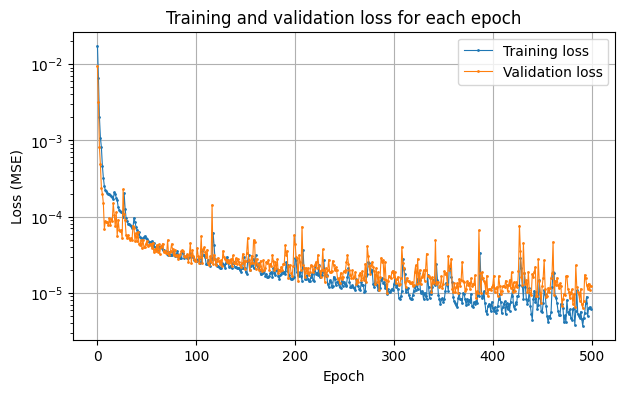

In [59]:
filename = 'plots/1D_CNN_sphere_loss.pdf'
plot_losses(loss_train, loss_val, save_plots, filename)

### Make predictions

In [60]:
# Make predictions
model.eval()
with torch.no_grad():
    pred_train = model(X_input).cpu().detach().numpy()
    pred_val = model(X_input_val).cpu().detach().numpy()
    pred_test = model(X_input_test).cpu().detach().numpy()

# Combine pred_train, pred_val and pred_test
pred_all = np.concatenate([pred_train, pred_val, pred_test], axis=0)
print(pred_all.shape)

train_loss = loss_fn(torch.tensor(pred_train), torch.tensor(u[seq_length:n_train, 0, :])).item()
val_loss = loss_fn(torch.tensor(pred_val), torch.tensor(u[n_train + seq_length:n_train + n_val, 0, :])).item()
test_loss = loss_fn(torch.tensor(pred_test), torch.tensor(u[n_train + n_val + seq_length:, 0, :])).item()

print(f"Train loss: {train_loss:.2e}")
print(f"Validation loss: {val_loss:.2e}")
print(f"Test loss: {test_loss:.2e}")

# Save the test loss MSE
if save_results:
    file_path = os.path.join(folder_path, f'1D_CNN_sphere_sigma={sigma}_MSE_test.txt')
    with open(file_path, 'w') as f:
        f.write(f"{test_loss:.2e}") # Save with 2 decimals

X_all, Y_all = prepare_data_sequences(torch.tensor(a, dtype=torch.float32), torch.tensor(u, dtype=torch.float32), 10)

# Predictions
model.eval()  # Set to evaluation mode
with torch.no_grad():  # Disable gradient computation 
    predictions = model(X_all)  # Full dataset
    overall_loss = loss_fn(predictions, Y_all)
    print(f"Overall loss: {overall_loss.item():.2e}")

(371, 500)
Train loss: 5.52e-06
Validation loss: 1.25e-05
Test loss: 3.87e-05
Overall loss: 1.35e-05


In [61]:
# Calculate MAE 
loss_new = nn.L1Loss()

train_loss = loss_new(torch.tensor(pred_train), torch.tensor(u[seq_length:n_train, 0, :])).item()
val_loss = loss_new(torch.tensor(pred_val), torch.tensor(u[n_train + seq_length:n_train + n_val, 0, :])).item()
test_loss = loss_new(torch.tensor(pred_test), torch.tensor(u[n_train + n_val + seq_length:, 0, :])).item()

print(f"Train loss: {train_loss:.2e}")
print(f"Validation loss: {val_loss:.2e}")
print(f"Test loss: {test_loss:.2e}")

# Save the test loss MAE
if save_results:
    file_path = os.path.join(folder_path, f'1D_CNN_sphere_sigma={sigma}_MAE_test.txt')
    with open(file_path, 'w') as f:
        f.write(f"{test_loss:.2e}") # Save with 2 decimals

# Add dimension to Y_all
pred_all = predictions.unsqueeze(1)
pred_all.shape, u[:-seq_length].shape
pred_all = pred_all.cpu().detach().numpy()

Train loss: 9.83e-04
Validation loss: 1.75e-03
Test loss: 2.74e-03


### Plot predictions

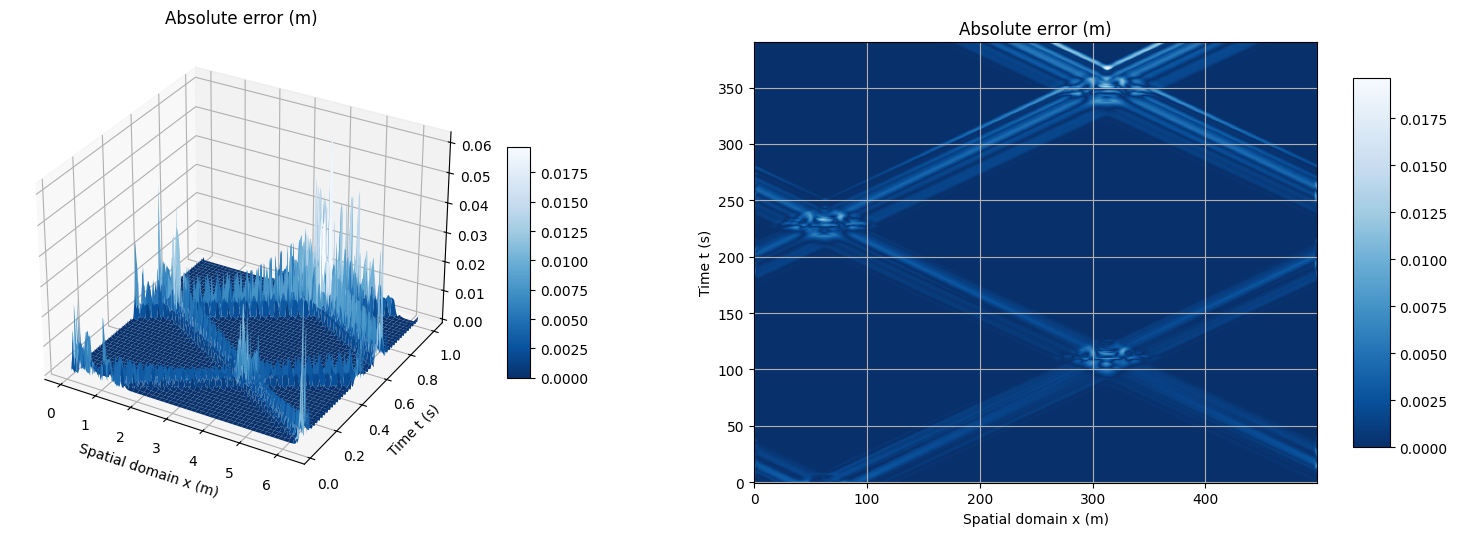

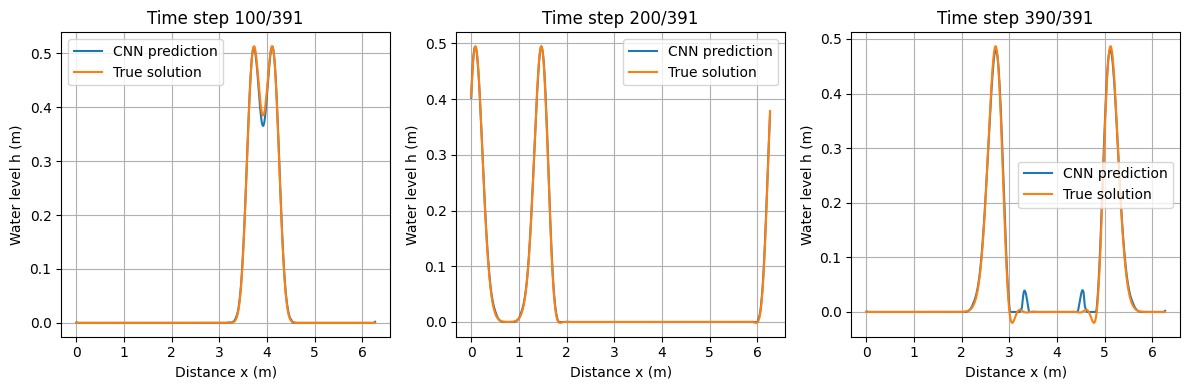

In [62]:
plot_error(pred_all, u[seq_length:], mesh, t_all[seq_length:], save=save_plots, figname=f'plots/1D_CNN_sphere_error_sigma={sigma}.pdf')

indices = [100, 200, 390]
labels = ['CNN prediction', 'True solution']
plot_predictions_time_steps(pred_all, u[seq_length:], mesh, indices, save=save_plots, figname=f'plots/1D_CNN_sphere_pred_timesteps_sigma={sigma}.pdf', labels=labels)

(391,)


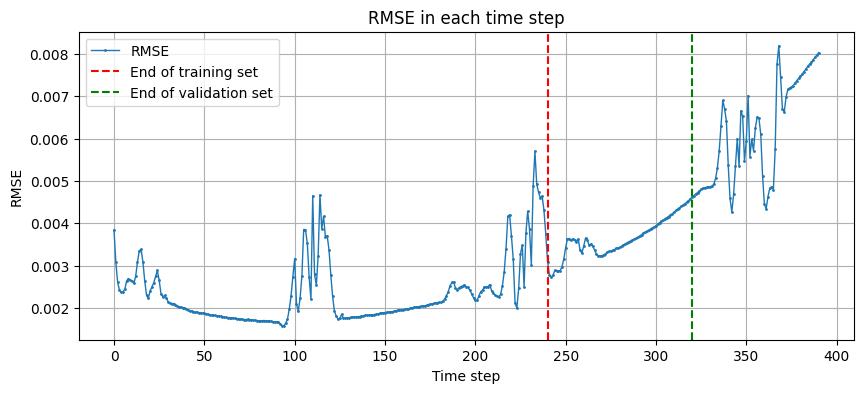

In [63]:
plot_RMSE(pred_all, u[seq_length:], n_train, n_val, save=save_plots, figname=f'plots/1D_CNN_sphere_RMSE_sigma={sigma}.pdf')

# FNO

### Load data from h5 file

In [64]:
# Construct the file path dynamically
file_path = rf'C:\Users\Matteo\Shallow-Water-Equations\dataFNO\linear-SWE-sphere-1d_sigma={sigma},T=1.h5'

# Load data
with h5py.File(file_path, 'r') as file:
    for key in file.keys():
        print(key)
        # Check if each key is a dataset or a group
        item = file[key]
        if isinstance(item, h5py.Group):
            print(f"  '{key}' is a group containing:")
            for sub_key in item.keys():
                if sub_key.startswith("__"):
                    continue
                print(f"    {sub_key}")
        elif isinstance(item, h5py.Dataset):
            print(f" '{key}' is a dataset with shape {item.shape} and dtype {item.dtype}")

    h_all = np.array(file['data_0']['h_storage'])
    t_all = np.array(file['data_0']['t_storage'])
    theta_all = np.array(file['data_0']['theta'])
    theta_all = theta_all[:,:-1]

print(f'Loaded h_all with shape {h_all.shape}')
print(f'Loaded t_all with shape {t_all.shape}')
print(f'Loaded theta_all with shape {theta_all.shape}')

data_0
  'data_0' is a group containing:
    h_storage
    t_storage
    theta
Loaded h_all with shape (402, 500)
Loaded t_all with shape (402, 1)
Loaded theta_all with shape (1, 500)


### Define model

In [65]:
model = TFNO(
    n_modes=(16,), 
    in_channels=1,
    lifting_channels=64, 
    hidden_channels=64, 
    projection_channels=64, 
    out_channels=1, 
    non_linearity=torch.functional.F.relu)

n_params = count_model_params(model)
print(f'\nThe model has {n_params} parameters.')


The model has 308929 parameters.


### Prepare data

In [66]:
p_train = 0.6
p_val = 0.2
p_test = 1 - p_train - p_val
n_train, n_val, n_test, mesh, a_with_mesh, u_with_mesh, a, u, n, train_x, train_y, val_x, val_y, test_x, test_y = prepare_data(h_all, theta_all, p_train, p_val)

batch_size = 32

train_dataset = torch.utils.data.TensorDataset(train_x, train_y)
dataloader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

val_dataset = torch.utils.data.TensorDataset(val_x, val_y)
dataloader_val = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

learn_rate = 1e-3
# Loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

(401, 2, 500)
(401, 2, 500)
401
n_train = 240, n_val = 80, n_test = 81
torch.Size([240, 1, 500]) torch.Size([240, 1, 500]) torch.Size([80, 1, 500]) torch.Size([80, 1, 500]) torch.Size([81, 1, 500]) torch.Size([81, 1, 500])


### Train model

In [67]:
loss_train = []
loss_val = []
best_val_loss = np.inf

model.to(device)

# Time training
start_time = time.time()

# Training loop
n_epochs = n_epochs_FNO
for epoch in tqdm(range(n_epochs), unit='epoch'):
    model.train()
    epoch_train_loss = 0

    for x, y in dataloader_train:
        x = x.to(device)
        y = y.to(device)

        # Forward pass
        y_pred = model(x)
        loss = loss_fn(y_pred, y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate epoch loss
        epoch_train_loss += loss.item() * x.size(0) # loss.item() is the average loss of the batch

    # Validation loss
    model.eval() # Set model to evaluation mode
    epoch_val_loss = 0
    with torch.no_grad(): # Disable gradient tracking
        for x_val, y_val in dataloader_val:
            x_val = y_val.to(device)
            y_val = y_val.to(device)
            val_y_pred = model(x_val)
            val_loss = loss_fn(val_y_pred, y_val)
            epoch_val_loss += val_loss.item() * x_val.size(0) 
            

    # Average losses
    epoch_train_loss /= len(train_dataset)
    epoch_val_loss /= len(val_dataset)

    # Append losses
    loss_train.append(epoch_train_loss)
    loss_val.append(epoch_val_loss)

    # Print epoch loss
    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{n_epochs}: Training loss: {epoch_train_loss:.6f}, Validation loss: {epoch_val_loss:.6f}')

# Time training
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

  0%|          | 0/500 [00:00<?, ?epoch/s]

Epoch 0/500: Training loss: 0.017503, Validation loss: 0.011274
Epoch 10/500: Training loss: 0.000436, Validation loss: 0.000167
Epoch 20/500: Training loss: 0.000348, Validation loss: 0.000119
Epoch 30/500: Training loss: 0.000310, Validation loss: 0.000106
Epoch 40/500: Training loss: 0.000308, Validation loss: 0.000135
Epoch 50/500: Training loss: 0.000283, Validation loss: 0.000123
Epoch 60/500: Training loss: 0.000292, Validation loss: 0.000126
Epoch 70/500: Training loss: 0.000263, Validation loss: 0.000152
Epoch 80/500: Training loss: 0.000260, Validation loss: 0.000262
Epoch 90/500: Training loss: 0.000259, Validation loss: 0.000346
Epoch 100/500: Training loss: 0.000191, Validation loss: 0.000627
Epoch 110/500: Training loss: 0.000129, Validation loss: 0.000894
Epoch 120/500: Training loss: 0.000115, Validation loss: 0.000937
Epoch 130/500: Training loss: 0.000133, Validation loss: 0.000904
Epoch 140/500: Training loss: 0.000096, Validation loss: 0.000945
Epoch 150/500: Traini

In [68]:
# Save the training time
# Specify folder path (create the folder if it doesn't exist)
folder_path = 'C:/Users/Matteo/Shallow-Water-Equations/saved_results'
os.makedirs(folder_path, exist_ok=True)  # Create the folder if it doesn't exist

# Save the training time
if save_results:
    file_path = os.path.join(folder_path, f'1D_FNO_sphere_sigma={sigma}_time.txt')
    with open(file_path, 'w') as f:
        f.write(f"{training_time:.2f}") # Save with 2 decimals

    # Save n_epochs
    file_path = os.path.join(folder_path, f'1D_FNO_sphere_sigma={sigma}_nepochs.txt')
    with open(file_path, 'w') as f:
        f.write(f"{n_epochs_FNO}") 

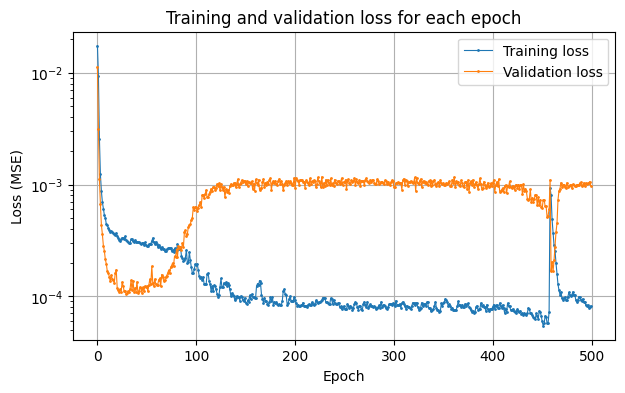

In [69]:
filename = 'plots/1D_FNO_sphere_loss.pdf'
plot_losses(loss_train, loss_val, save_plots, filename)

### Make predictions

In [70]:
# Make predictions
model.eval()
with torch.no_grad():
    pred_train = model(train_x).cpu().detach().numpy()
    pred_val = model(val_x).cpu().detach().numpy()
    pred_test = model(test_x).cpu().detach().numpy()

# Combine pred_train, pred_val and pred_test
pred_all = np.concatenate([pred_train, pred_val, pred_test], axis=0)
print(pred_all.shape)

# Calculate loss
train_loss = loss_fn(torch.tensor(pred_train[:, 0, :]), torch.tensor(u[:n_train, 0, :])).item()
val_loss = loss_fn(torch.tensor(pred_val[:, 0, :]), torch.tensor(u[n_train:n_train + n_val, 0, :])).item()
test_loss = loss_fn(torch.tensor(pred_test[:, 0, :]), torch.tensor(u[n_train + n_val:, 0, :])).item()
all_loss = loss_fn(torch.tensor(pred_all[:, 0, :]), torch.tensor(u[:, 0, :])).item()

print(f"Train loss: {train_loss:.2e}")
print(f"Validation loss: {val_loss:.2e}")
print(f"Test loss: {test_loss:.2e}")
print(f"All loss: {all_loss:.2e}")

# Save the test loss MSE
if save_results:
    file_path = os.path.join(folder_path, f'1D_FNO_sphere_sigma={sigma}_MSE_test.txt')
    with open(file_path, 'w') as f:
        f.write(f"{test_loss:.2e}") # Save with 2 decimals

(401, 1, 500)
Train loss: 8.27e-05
Validation loss: 2.84e-04
Test loss: 5.44e-04
All loss: 2.16e-04


In [71]:
# Calculate MAE 
loss_new = nn.L1Loss()

train_loss = loss_new(torch.tensor(pred_train[:, 0, :]), torch.tensor(u[:n_train, 0, :])).item()
val_loss = loss_new(torch.tensor(pred_val[:, 0, :]), torch.tensor(u[n_train:n_train + n_val, 0, :])).item()
test_loss = loss_new(torch.tensor(pred_test[:, 0, :]), torch.tensor(u[n_train + n_val:, 0, :])).item()
all_loss = loss_new(torch.tensor(pred_all[:, 0, :]), torch.tensor(u[:, 0, :])).item()

print(f"Train loss: {train_loss:.2e}")
print(f"Validation loss: {val_loss:.2e}")
print(f"Test loss: {test_loss:.2e}")
print(f"All loss: {all_loss:.2e}")

# Save the test loss MAE
if save_results:
    file_path = os.path.join(folder_path, f'1D_FNO_sphere_sigma={sigma}_MAE_test.txt')
    with open(file_path, 'w') as f:
        f.write(f"{test_loss:.2e}") # Save with 2 decimals

Train loss: 4.19e-03
Validation loss: 7.88e-03
Test loss: 1.02e-02
All loss: 6.14e-03


### Plot predictions

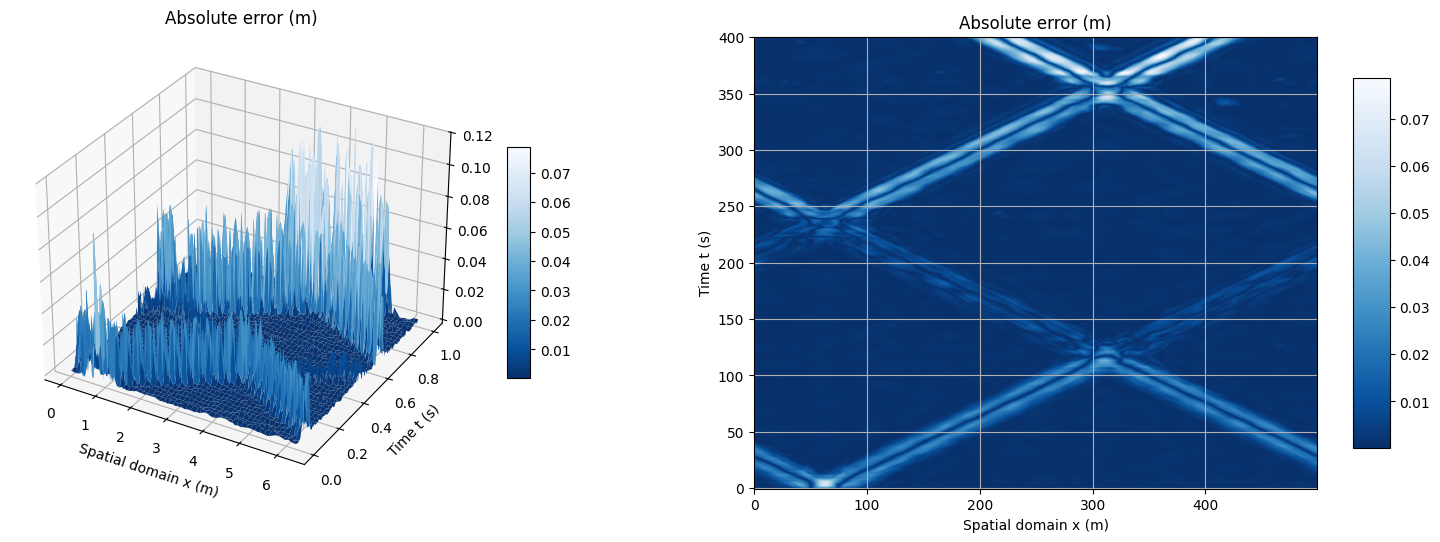

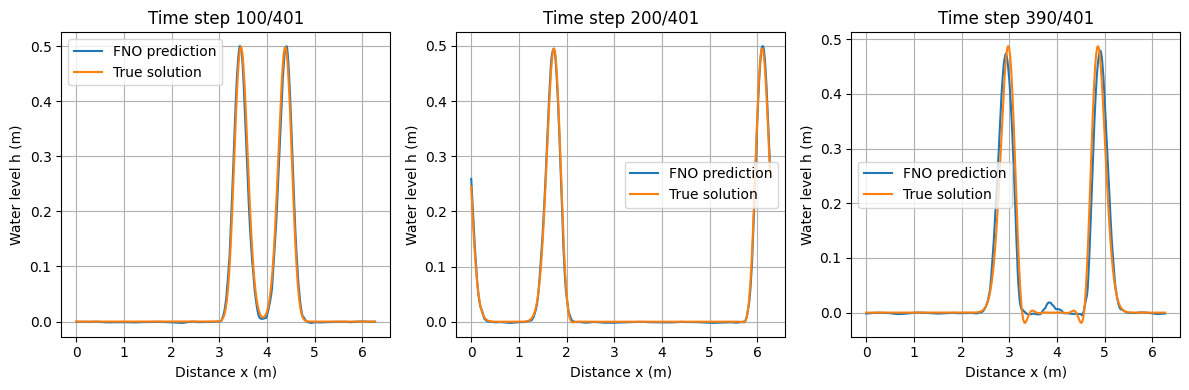

In [72]:
plot_error(pred_all, u, mesh, t_all, save=save_plots, figname=f'plots/1D_FNO_sphere_error_sigma={sigma}.pdf')

indices = [100, 200, 390]
labels = ['FNO prediction', 'True solution']
plot_predictions_time_steps(pred_all, u, mesh, indices, save=save_plots, figname=f'plots/1D_FNO_sphere_pred_timesteps_sigma={sigma}.pdf', labels=labels)